# Exploration 10. 인공지능으로 세상에 없던 새로운 패션 만들기 🎠🎡🎁🎨

🎀 데이터셋: Fashion MNIST   
🎀 https://github.com/zalandoresearch/fashion-mnist

## 데이터 전처리하기
### Step 1. 라이브러리 설치여부 확인하기

In [ ]:
# $ pip list | grep -E 'imageio|Pillow'
# imageio, pillow 라이브러리가 없을 경우 설치하세요.

# $ pip install imageio
# $ pip install Pillow
# 그리고 다음과 같이 작업환경을 구성합시다.

# $ mkdir -p ~/aiffel/dcgan_newimage/fashion/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/fashion/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/fashion/training_history

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


#### 🎀 파이썬 언더스코어(_)  
> _는 또한 어떤 특정값을 무시하기 위한 용도로 사용되기도한다. 값이 필요하지 않거나 사용되지 않는 값을 _에 할당하기만 하면된다.

### Step 2. 데이터셋 가져오기
- `load_data()`로 데이터를 로딩
- 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없다. 우리가 MNIST 데이터로 분류 문제를 풀었을 때 필요했던 `y_train`, `y_test`에 해당하는 데이터 쓰지 않으므로 언더스코어(_)로 무시

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


🎀 Fashion MNIST 또한 MNIST와 같이 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가진다.
### Step 3. 정규화하기
- 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠준다

In [6]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


#### - 데이터셋의 shape 출력해보기

In [9]:
train_x.shape

(60000, 28, 28)

🎀 6만 장의 이미지  
🎀 각 이미지의 사이즈는 28x28
### Step 4. 데이터셋의 shape에 채널 수에 대한 차원 1(grayscale) 추가하기
- CNN(합성곱) 계층을 다룰 때 배웠듯, 딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요
- R, G, B 세 개의 채널이 있고, Gray Scale(흑백)의 경우 1개의 채널
- Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1

In [10]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

#### - 첫번째 데이터 꺼내보기 

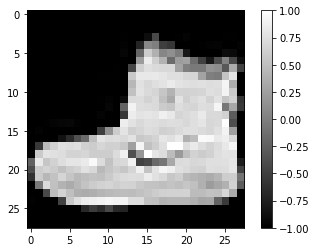

In [11]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

🎀 `plt.colorbar()` 를 이용해 오른쪽에 각 픽셀의 값과 그에 따른 색 확인함 
- 픽셀에는 정규화 해준 대로 -1 ~ 1 사이의 값을 가진다
- -1이 가장 어두운 검은색, 1이 가장 밝은 흰색

####  - for 문을 활용 데이터 10개 띄워보기

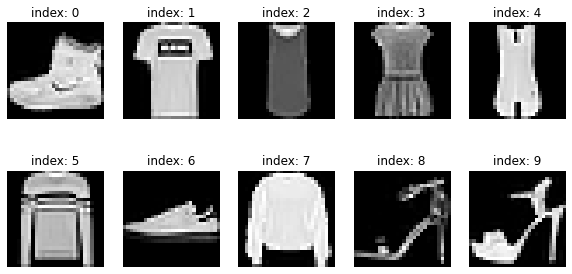

In [12]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

#### - 이미지 25개를 5x5 의 배열로 띄워보기
- `np.random.randint()`를 사용하여 train_images에서 랜덤으로 추출

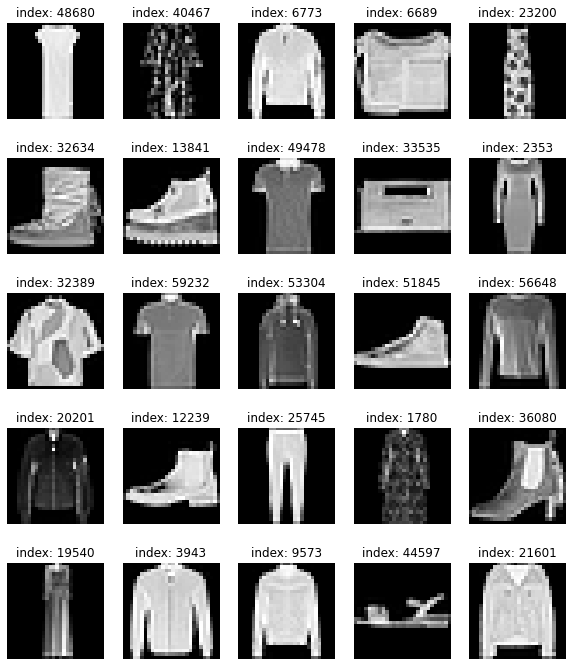

In [13]:
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

### Step 5. 정리된 데이터를 모델에 넣어 편하게 학습시킬 수 있도록 텐서플로우의 Dataset을 이용해 준비하기


In [14]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256  # minibatch

🎀 BUFFER_SIZE은 전체 데이터를 섞기 위해 60,000으로 설정, `shuffle()` 함수가 데이터셋을 잘 섞어서 모델에 넣음  
🎀 BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양, 미니 배치 학습

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 🎁 TIP
> - tf.data.Dataset 모듈의 `from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.
>- 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 
> - 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

## DCGAN(Deep Convolutional GAN) 모델 구현하기
- Keras Sequential API를 활용
- https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko 참고

### Step 1. 생성자(Generator) 구현하기

In [16]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

## 🎁 정리
- `make_generator_model`이라는 함수를 만들어서 언제든 생성자를 생성
- `tf.keras.Sequential()`로 모델을 시작한 후 레이어 쌓기

#### - Conv2DTranspose 레이어
- Conv2D와 달리 이미지 사이즈를 넓혀주는 층
- 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나간다
- 최종 사이즈인 `(28, 28, 1)`은 우리가 준비했던 데이터셋과 형상이 동일

#### - BatchNormalization 레이어
- 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜준다

#### - 활성화함수
- `LeakyReLU`를 사용
- 마지막 층에는 활성화 함수로 `tanh`를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

🎀 모델 입력값: (batch_size, 100) 형상의 노이즈 벡터  
🎀 처음 입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됩니다.  
🎀 첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 됩니다.  
> 이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업입니다.

### Step 2. 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력하기

In [17]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### Step 3.shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물 만들어보기
> `tf.random.normal`를 이용하여 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 만들기  
🎀 아직 모델이 학습되지 않았으니, 아마 결과물도 큰 의미가 있지는 않음 주의

In [18]:
noise = tf.random.normal([1, 100])

#### - 학습하는 중이 아니니 training=False 설정
> Batch Normalization 레이어는 훈련 시기와 추론(inference) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있다.

In [19]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

🎀 첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (28, 28, 1) 사이즈 이미지가 생성되었다는 뜻
#### - 이미지 시각화해보기
> matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로   
  0번째와 3번째 축의 인덱스를 0으로 설정해서   
  (28, 28) shape의 이미지를 꺼낼 수 있도록 해야한다.

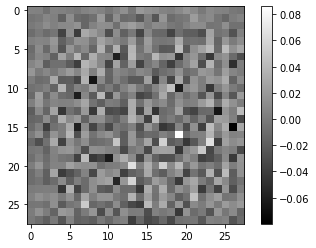

In [20]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

🎀  -1과 1 사이의 값에서 적당히 잘 생성됨   
🎀 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지 생성

### Step 4. 판별자(Discriminator) 구현하기

In [22]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

## 🎁 정리
- `make_discriminator_model` 함수로 구현

#### Conv2DTranspose 층
- 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다
- 첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)

#### Flatten 층
- 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 

#### Dense Layer
1차원 벡터로 변환한 후 Dense layer를 거쳐 단 하나의 값을 출력한다.

#### - 🎀 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력해보기

In [23]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

#### - 아까 생성했던 가짜 이미지를 판별자에 입력
> 텐서플로우의 텐서 형태로 출력 - 아직까지는 아무런 의미 없음!

In [24]:
decision = discriminator(generated_image, training=False)
decision  

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00092654]], dtype=float32)>

## 손실함수와 최적화 함수

### 🎁 모델 학습을 위한 재료
#### (1) 손실함수 (loss function)
- GAN은 손실함수로 `교차 엔트로피(Cross Entropy)`를 사용
- `tf.keras.losses` 라이브러리
-  Real Image에 대한 라벨이 1, Fake Image에 대한 라벨이 0 일 때,
> 🎀 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것     
🎀 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것
- 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있다. 
> 🎀 그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정  
🎀 `from_logits`를 `True`로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화
- `y_pred (predicted value)`: This is the model's prediction, i.e, a single floating-point value which either represents a logit, (i.e, value in [-inf, inf] when from_logits=True) or a probability (i.e, value in [0., 1.] when from_logits=False).

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

🎀 fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)  
🎀 real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)
> `tf.ones_like()`와 `tf.zeros_like()` 함수 활용

In [26]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

## 🎠 discriminator_loss
- discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산한다.
> discriminator_loss = real_loss + fake_loss
- `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 🎠 discriminator accuracy
- real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산
- 따로 계산해서 비교해 보기
> (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])  
(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])  
(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 🎠 최적화 함수(optimizer)
###  Adam 최적화 기법 활용
- `tf.keras.optimizers` 안에 있음
- `learning rate`는 0.0001  
🎀 학습 품질을 올려보고 싶다면 하이퍼 파라미터를 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천  
🎀  생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### - 샘플 한 번에 16장을 생성하여 학습이 어떻게 진행되어가고 있는지 확인하기
- 고정된 seed 노이즈: 같은 노이즈로 생성해야 그에 대한 진전 과정 확인 가능
- 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들기

In [30]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 설계

#### `train_step` 함수 만들기
- `@tf.function` 이라는 데코레이터를 붙여서 사용  

In [31]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [32]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

### 🎀 `@tf.function` 
데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환

- `train_step` 함수를 하나하나 뜯어보면 다음과 같습니다.

(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성  
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력  
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산  
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신  
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [33]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### - 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기

In [35]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

1. model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정
    - 🎀 subplot을 이용해서 총 16개의 sample을 시각화하는 과정입니다. 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화  
2. plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장  
3. train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수 만들기  
4. 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### 🎀 `tf.train.Checkpoint`
- 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리 가능
- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장
- 작업환경 내에 `training_checkpoints` 라는 디렉토리 사용

In [36]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 모델 학습시키기
- train_step, 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 학습 과정을 시각화하는 draw_train_history(), 그리고 모델까지 저장하기 위한 checkpoint까지 모두 준비가 되었으니 이것들을 한곳에 합치기

In [37]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

#### - 생성된 샘플을 시각화하거나 원하는 시간을 출력하기
- print문과 몇 번마다 출력하는지에 대한 구문을 원하는 대로 수정
- `save_every`와 전체 학습 에포크를 결정하는 `EPOCHS` 파라미터도 설정해 준 후 훈련시키기 
- `train()` 함수를 실행시키면 드디어 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인
>본 학습은 이미지를 활용한 것이기 때문에 CPU 환경에서는 매우 느릴 수 있습니다.  
RTX2070 또는 구글 Colab의 T4 정도 사양의 경우 1 Epoch 당 10초가 걸리는 반면, 일반적인 CPU 환경에서는 최소 3분에서 10분 이상이 걸릴 수 있으므로 최대한 GPU 환경에서 실습해 보는 것을 추천

In [ ]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

#### 🎠 만약 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면,    생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻
- 더욱 많은 epoch으로 학습을 시켜야 함 !! 
- 단순히 학습 수행 시간만 늘리는 것보다, 모델 구조나 학습 방법을 바꾸어 봐야 할 수도 있다

## 학습과정 시각화하기
- 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어보기
> 1. GIF 파일은 우리가 오래전에 import 해놓았던 `imageio 라이브러리`를 활용  
> 2. `imageio.get_writer`를 활용해서 파일을 열고, 
> 3. `append_data`로 이미지를 하나씩 붙여나가는 방식
> 4. 실행되면, `fasion_mnist_dcgan.gif` 파일이 저장되어 있는 것을 확인

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

클라우드에서는 확인을 위하여 cloud jupyrer를 열어서 ~/aiffel/dcgan_newimage/fashion/ 폴더 경로에 fashion_mnist_dcgan.gif를 클릭하시면 생성자가 만들어내는 이미지의 품질이 점점 개선되어 가는 과정을 한눈에 볼 수 있다.